In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf

import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from matplotlib.ticker import FuncFormatter

from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, mean_squared_error

import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor


2024-02-11 11:14:45.832744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Understanding and Preprocessing:

Begin by understanding the structure and content of your dataset. Ensure that you have a clear understanding of each feature and its significance.
Preprocess your data, which may include handling missing values, encoding categorical variables, and scaling numerical features if necessary.

In [2]:
"""
sample_submission = pd.read_csv("/kaggle/input/iyzico-datathon/sample_submission.csv")
base_train = pd.read_csv("/kaggle/input/iyzico-datathon/train.csv")
"""

sample_submission = pd.read_csv("sample_submission.csv")
base_train = pd.read_csv("train.csv")

In [3]:
base_train

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...,...
291137,merchant_67083,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3


In [4]:
base_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291142 entries, 0 to 291141
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  object
 1   month_id              291142 non-null  int64 
 2   merchant_source_name  291142 non-null  object
 3   settlement_period     291142 non-null  object
 4   working_type          291142 non-null  object
 5   mcc_id                291142 non-null  object
 6   merchant_segment      291142 non-null  object
 7   net_payment_count     291142 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 17.8+ MB


In [5]:
base_train.describe()

,month_id,net_payment_count
count,291142.000000,2.911420e+05
mean,202159.680860,4.153842e+02
std,104.214948,1.082067e+04
min,202001.000000,-1.433000e+03
25%,202103.000000,4.000000e+00
50%,202201.000000,6.000000e+00
75%,202211.000000,1.400000e+01
max,202309.000000,1.160429e+06


In [6]:
print(f"Unique values for merchant id {base_train['merchant_id'].nunique()}")
print(f"Unique values for month id {base_train['month_id'].nunique()}")
print(f"Unique values for merchant_source_name {base_train['merchant_source_name'].nunique()}")
print(f"Unique values for settlement_period {base_train['settlement_period'].nunique()}")
print(f"Unique values for working_type {base_train['working_type'].nunique()}")
print(f"Unique values for mcc_id {base_train['mcc_id'].nunique()}")
print(f"Unique values for merchant_segment {base_train['merchant_segment'].nunique()}")
print(f"Unique values for net_payment_count {base_train['net_payment_count'].nunique()}")

Unique values for merchant id 26060
Unique values for month id 45
Unique values for merchant_source_name 3
Unique values for settlement_period 3
Unique values for working_type 6
Unique values for mcc_id 172
Unique values for merchant_segment 4
Unique values for net_payment_count 5039


In [7]:
for column in base_train.columns:
    print(base_train[column].value_counts())

merchant_id
merchant_43992    45
merchant_19380    45
merchant_1100     45
merchant_17200    45
merchant_65293    45
                  ..
merchant_3063      1
merchant_35756     1
merchant_50399     1
merchant_56272     1
merchant_66895     1
Name: count, Length: 26060, dtype: int64
month_id
202112    7413
202303    7367
202203    7332
202305    7327
202308    7315
202309    7287
202204    7244
202307    7217
202201    7210
202301    7198
202304    7191
202212    7153
202111    7129
202211    7086
202210    7073
202205    7072
202306    7065
202202    7064
202105    7045
202206    7040
202109    7021
202110    7018
202106    7004
202209    6967
202103    6883
202104    6878
202208    6876
202302    6804
202108    6771
202207    6648
202102    6607
202107    6490
202101    6437
202012    6352
202011    5887
202010    5654
202009    5489
202008    5224
202007    4990
202006    4920
202005    4707
202004    4120
202003    3951
202002    3867
202001    3749
Name: count, dtype: int64
mercha

In [8]:
test_data = sample_submission.copy()
test_data

,id,net_payment_count
0,202311merchant_36004,0
1,202312merchant_36004,0
2,202310merchant_36004,0
3,202311merchant_23099,0
4,202312merchant_23099,0
...,...,...
78175,202312merchant_35969,0
78176,202310merchant_35969,0
78177,202311merchant_8429,0
78178,202312merchant_8429,0


In [9]:
test_data[['month_id', 'merchant_id']] = test_data['id'].str.extract(r'(\d{6})(merchant_\d+)')
test_data

,id,net_payment_count,month_id,merchant_id
0,202311merchant_36004,0,202311,merchant_36004
1,202312merchant_36004,0,202312,merchant_36004
2,202310merchant_36004,0,202310,merchant_36004
3,202311merchant_23099,0,202311,merchant_23099
4,202312merchant_23099,0,202312,merchant_23099
...,...,...,...,...
78175,202312merchant_35969,0,202312,merchant_35969
78176,202310merchant_35969,0,202310,merchant_35969
78177,202311merchant_8429,0,202311,merchant_8429
78178,202312merchant_8429,0,202312,merchant_8429


In [10]:
data = base_train.copy() 
data['month_id'] = pd.to_datetime(data['month_id'], format='%Y%m')
test_data['month_id'] = pd.to_datetime(test_data['month_id'], format='%Y%m')
data.set_index('month_id', inplace=True)
test_data.set_index('month_id', inplace=True)

test_data

,id,net_payment_count,merchant_id
month_id,,,
2023-11-01,202311merchant_36004,0,merchant_36004
2023-12-01,202312merchant_36004,0,merchant_36004
2023-10-01,202310merchant_36004,0,merchant_36004
2023-11-01,202311merchant_23099,0,merchant_23099
2023-12-01,202312merchant_23099,0,merchant_23099
...,...,...,...
2023-12-01,202312merchant_35969,0,merchant_35969
2023-10-01,202310merchant_35969,0,merchant_35969
2023-11-01,202311merchant_8429,0,merchant_8429


In [11]:
cluster_data = data.copy() # Remove unnecessary columns
cluster_data = pd.get_dummies(cluster_data, columns= ["working_type", "merchant_segment", "merchant_source_name", "settlement_period"])  # One-hot encode categorical variables if necessary
cluster_data

,merchant_id,mcc_id,net_payment_count,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
month_id,,,,,,,,,,,,,,,,,,,
2023-07-01,merchant_43992,mcc_197,15106,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2023-01-01,merchant_43992,mcc_197,16918,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2023-05-01,merchant_43992,mcc_197,13452,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2023-08-01,merchant_43992,mcc_197,16787,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
2023-02-01,merchant_43992,mcc_197,12428,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,merchant_67083,mcc_169,4,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False
2023-09-01,merchant_4263,mcc_73,4,False,False,False,False,False,True,False,False,False,True,False,True,False,True,False,False
2023-09-01,merchant_11346,mcc_169,3,False,False,False,False,False,True,False,False,False,True,True,False,False,True,False,False


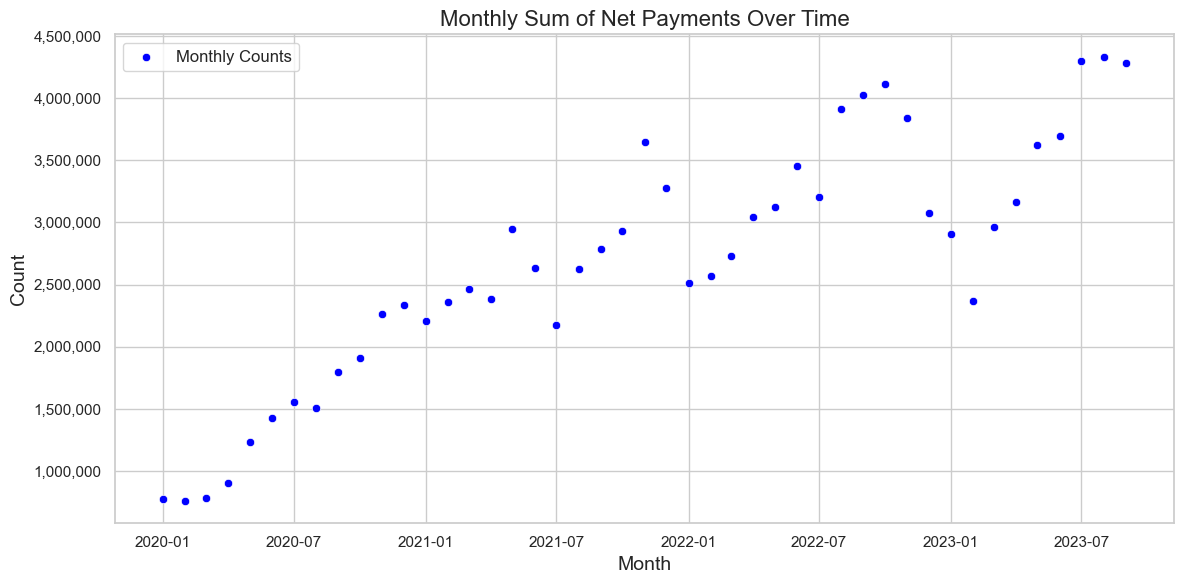

In [12]:
# Group by month_id and sum the net_payment_count for each month
monthly_counts = data.groupby('month_id')['net_payment_count'].sum()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=monthly_counts.reset_index(), x='month_id', y='net_payment_count', color='blue', label='Monthly Counts')

# Apply the formatting function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))


plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


In [13]:
monthly_counts

month_id
2020-01-01     775289
2020-02-01     759571
2020-03-01     784726
2020-04-01     906968
2020-05-01    1234374
2020-06-01    1424606
2020-07-01    1559296
2020-08-01    1508304
2020-09-01    1801105
2020-10-01    1907334
2020-11-01    2263692
2020-12-01    2335235
2021-01-01    2204802
2021-02-01    2358530
2021-03-01    2464850
2021-04-01    2388236
2021-05-01    2948518
2021-06-01    2636933
2021-07-01    2172452
2021-08-01    2625566
2021-09-01    2787039
2021-10-01    2934176
2021-11-01    3646847
2021-12-01    3275615
2022-01-01    2509716
2022-02-01    2568446
2022-03-01    2730111
2022-04-01    3042259
2022-05-01    3122160
2022-06-01    3453755
2022-07-01    3203420
2022-08-01    3909944
2022-09-01    4021619
2022-10-01    4111855
2022-11-01    3842774
2022-12-01    3075363
2023-01-01    2910984
2023-02-01    2368511
2023-03-01    2967131
2023-04-01    3161692
2023-05-01    3619637
2023-06-01    3694900
2023-07-01    4301209
2023-08-01    4333899
2023-09-01    4282338
N

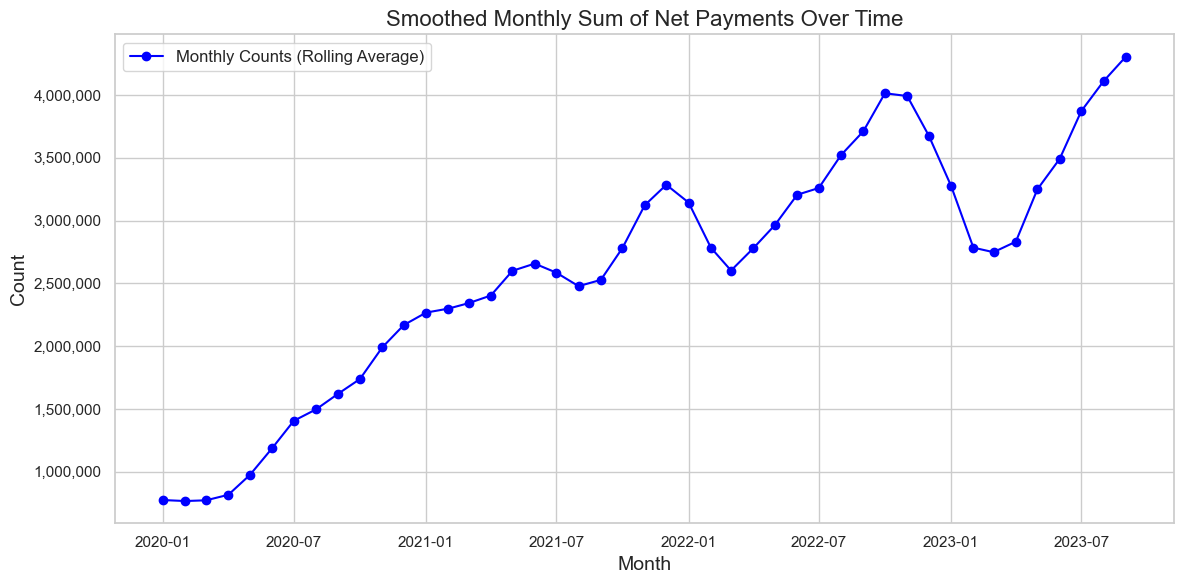

In [14]:
# Smooth out fluctuations using a rolling average
rolling_avg = monthly_counts.rolling(window=3, min_periods=1).mean()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(rolling_avg.index, rolling_avg.values, color='blue', marker='o', label='Monthly Counts (Rolling Average)')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Smoothed Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


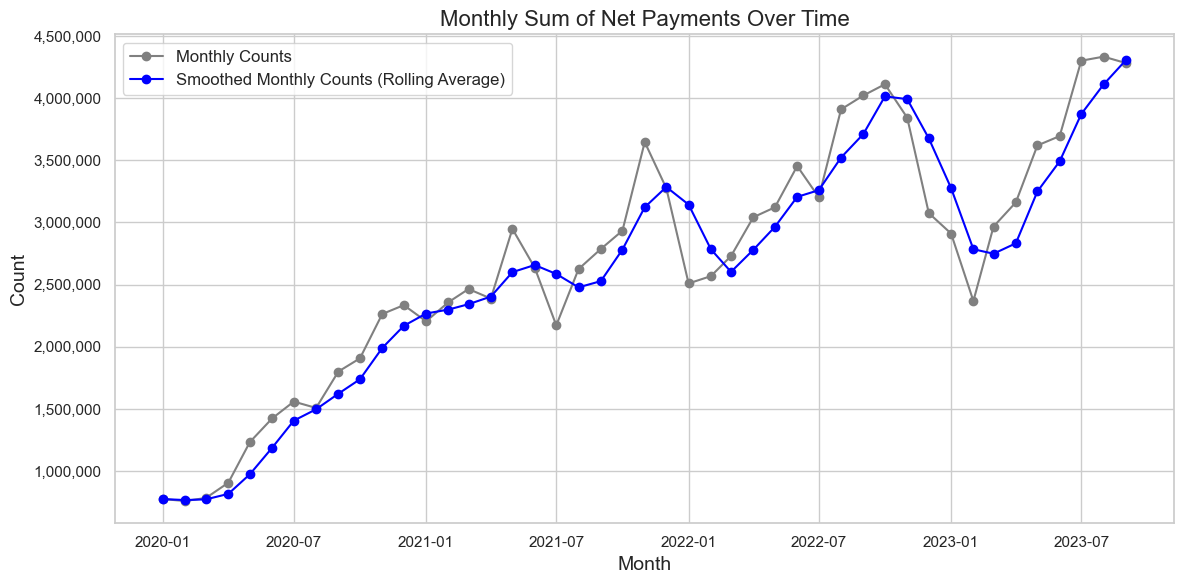

In [15]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot raw monthly counts
plt.plot(monthly_counts.index, monthly_counts.values, color='gray', marker='o', label='Monthly Counts')

# Plot smoothed monthly counts (rolling average)
plt.plot(rolling_avg.index, rolling_avg.values, color='blue', marker='o', label='Smoothed Monthly Counts (Rolling Average)')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


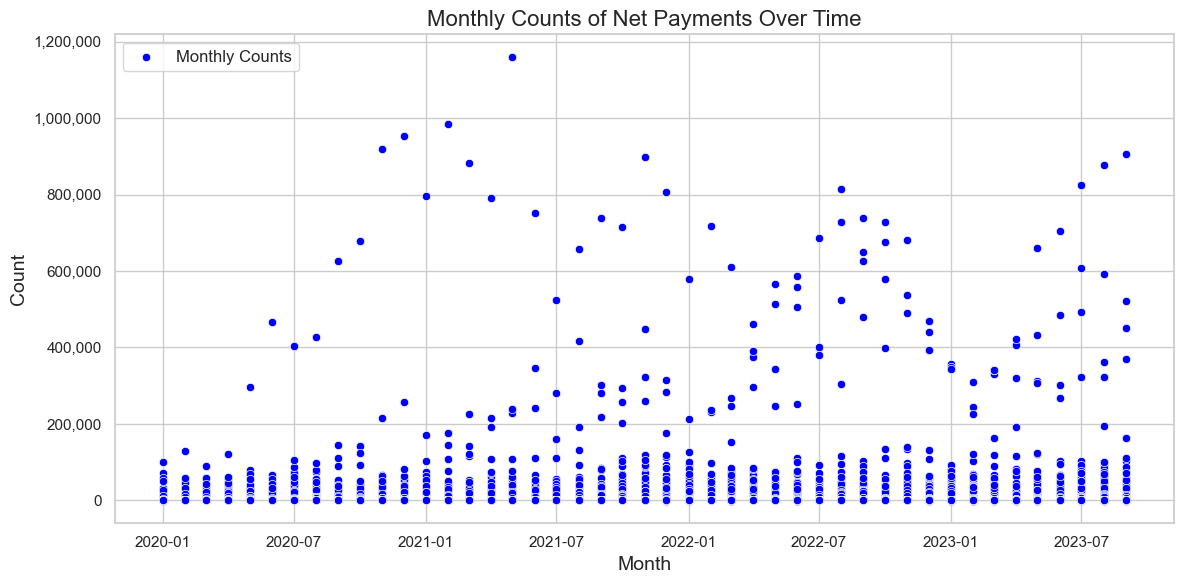

In [16]:
# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=data, x=data.index, y='net_payment_count', color='blue', label='Monthly Counts')

# Apply the formatting function to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Counts of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


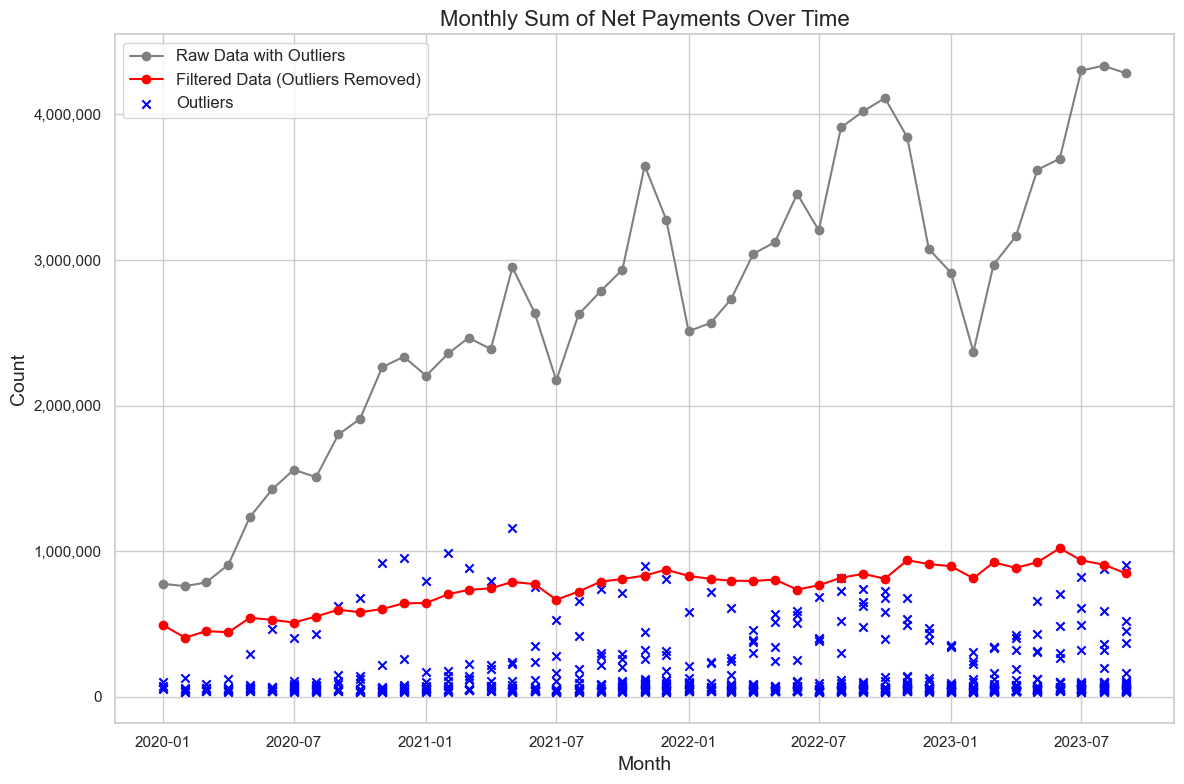

               merchant_id merchant_source_name      settlement_period  \
month_id                                                                 
2022-08-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-10-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-09-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-11-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
2022-07-01  merchant_60635  Merchant Source - 3  Settlement Period - 3   
...                    ...                  ...                    ...   
2023-09-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-06-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-07-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-08-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   
2023-04-01  merchant_28397  Merchant Source - 1  Settlement Period - 2   

                working_type  mcc_id 

In [17]:
# Calculate z-scores for each net_payment_count value
z_scores = (data['net_payment_count'] - data['net_payment_count'].mean()) / data['net_payment_count'].std()

# Define a threshold for outlier detection
threshold = 3

# Filter out data points with z-scores greater than the threshold (outliers)
outliers = data[abs(z_scores) >= threshold]

# Filter out data points with z-scores less than the threshold (non-outliers)
filtered_data = data[abs(z_scores) < threshold]

# Group by month_id and sum the net_payment_count for each month for both original and filtered data
monthly_counts = data.groupby('month_id')['net_payment_count'].sum()
filtered_monthly_counts = filtered_data.groupby('month_id')['net_payment_count'].sum()

# Set up a seaborn style for better aesthetics
sns.set(style="whitegrid", palette="husl")

# Define a function to format y-axis ticks
def format_ticks(value, _):
    return f'{int(value):,}'

# Plotting
plt.figure(figsize=(12, 8))

# Plot raw monthly counts with outliers
plt.plot(monthly_counts.index, monthly_counts.values, color='gray', marker='o', linestyle='-', label='Raw Data with Outliers')

# Plot filtered monthly counts without outliers
plt.plot(filtered_monthly_counts.index, filtered_monthly_counts.values, color='red', marker='o', linestyle='-', label='Filtered Data (Outliers Removed)')

# Plot outliers
plt.scatter(outliers.index, outliers['net_payment_count'], color='blue', marker='x', label='Outliers')

# Apply the formatting function to the y-axis
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

plt.title('Monthly Sum of Net Payments Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


print(outliers)

In [18]:
filtered_monthly_counts

month_id
2020-01-01     492688
2020-02-01     405168
2020-03-01     450770
2020-04-01     442833
2020-05-01     542148
2020-06-01     527956
2020-07-01     509598
2020-08-01     550956
2020-09-01     597776
2020-10-01     580397
2020-11-01     602543
2020-12-01     641520
2021-01-01     643672
2021-02-01     704566
2021-03-01     733865
2021-04-01     744509
2021-05-01     788636
2021-06-01     773155
2021-07-01     665935
2021-08-01     722447
2021-09-01     790539
2021-10-01     808594
2021-11-01     832466
2021-12-01     872492
2022-01-01     829663
2022-02-01     809121
2022-03-01     796954
2022-04-01     795284
2022-05-01     804361
2022-06-01     735903
2022-07-01     765352
2022-08-01     817059
2022-09-01     844192
2022-10-01     810168
2022-11-01     937601
2022-12-01     911592
2023-01-01     895599
2023-02-01     813539
2023-03-01     922567
2023-04-01     885303
2023-05-01     923227
2023-06-01    1019787
2023-07-01     936703
2023-08-01     907770
2023-09-01     847344
N

In [19]:
monthly_counts

month_id
2020-01-01     775289
2020-02-01     759571
2020-03-01     784726
2020-04-01     906968
2020-05-01    1234374
2020-06-01    1424606
2020-07-01    1559296
2020-08-01    1508304
2020-09-01    1801105
2020-10-01    1907334
2020-11-01    2263692
2020-12-01    2335235
2021-01-01    2204802
2021-02-01    2358530
2021-03-01    2464850
2021-04-01    2388236
2021-05-01    2948518
2021-06-01    2636933
2021-07-01    2172452
2021-08-01    2625566
2021-09-01    2787039
2021-10-01    2934176
2021-11-01    3646847
2021-12-01    3275615
2022-01-01    2509716
2022-02-01    2568446
2022-03-01    2730111
2022-04-01    3042259
2022-05-01    3122160
2022-06-01    3453755
2022-07-01    3203420
2022-08-01    3909944
2022-09-01    4021619
2022-10-01    4111855
2022-11-01    3842774
2022-12-01    3075363
2023-01-01    2910984
2023-02-01    2368511
2023-03-01    2967131
2023-04-01    3161692
2023-05-01    3619637
2023-06-01    3694900
2023-07-01    4301209
2023-08-01    4333899
2023-09-01    4282338
N

In [20]:
test_data

,id,net_payment_count,merchant_id
month_id,,,
2023-11-01,202311merchant_36004,0,merchant_36004
2023-12-01,202312merchant_36004,0,merchant_36004
2023-10-01,202310merchant_36004,0,merchant_36004
2023-11-01,202311merchant_23099,0,merchant_23099
2023-12-01,202312merchant_23099,0,merchant_23099
...,...,...,...
2023-12-01,202312merchant_35969,0,merchant_35969
2023-10-01,202310merchant_35969,0,merchant_35969
2023-11-01,202311merchant_8429,0,merchant_8429


## Exploratory Data Analysis (EDA):

Conduct EDA to gain insights into the distribution of your features, identify patterns, correlations, and outliers.
Visualize the time series data to understand its trend, seasonality, and any other patterns that might be present.

In [21]:
data

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
month_id,,,,,,,
2023-07-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
2023-01-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2023-05-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
2023-08-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
2023-02-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...
2023-09-01,merchant_67083,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
2023-09-01,merchant_4263,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
2023-09-01,merchant_11346,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3


In [22]:
def plot_payment_count_forecast(data, test, merchant_id):
    # Filter the DataFrame for a specific 'merchant_id'
    data_filtered = data[data['merchant_id'] == merchant_id]
    test_filtered = test[test['merchant_id'] == merchant_id]

    # Plotting the original data
    plt.figure(figsize=(10, 6))
    data_filtered['net_payment_count'].plot()
    plt.title('Net Payment Count Over Time')
    plt.xlabel('Month')
    plt.ylabel('Net Payment Count')

    # Fit the ARIMA model
    model = ARIMA(data_filtered['net_payment_count'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecasting future points
    forecast = model_fit.forecast(steps=3)

    # Update res_x with forecasted values
    test_filtered.loc[test_filtered.index[:3], 'net_payment_count'] = forecast.values

    # Plotting the forecasted points
    test_filtered['net_payment_count'].plot(style='r')

    plt.show()

    return test_filtered


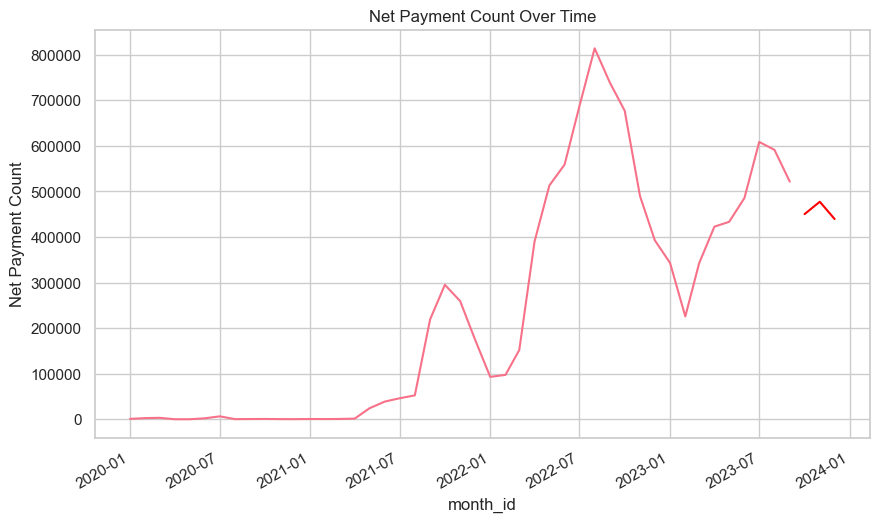

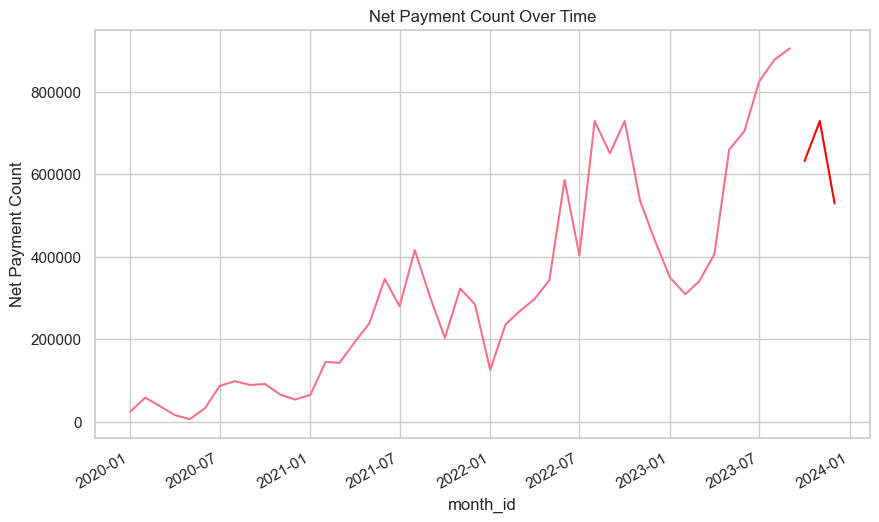

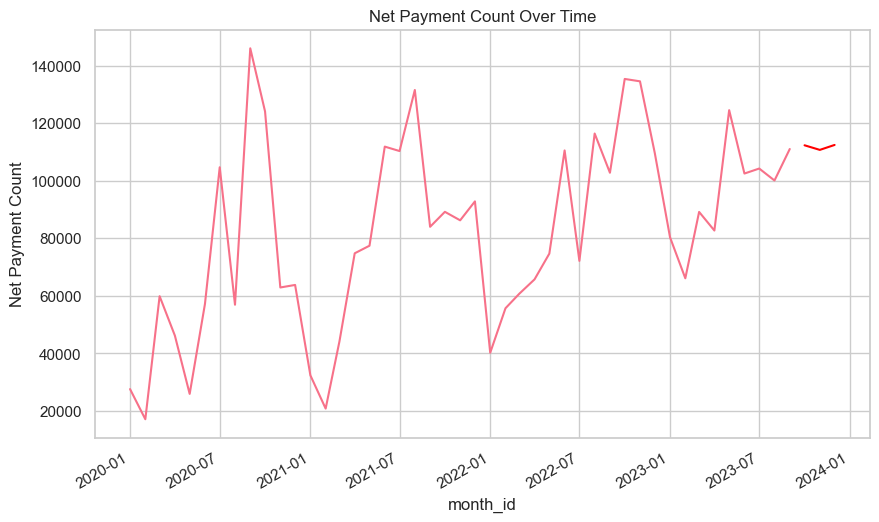

,id,net_payment_count,merchant_id
month_id,,,
2023-11-01,202311merchant_16119,110739.461984,merchant_16119
2023-12-01,202312merchant_16119,112456.836059,merchant_16119
2023-10-01,202310merchant_16119,112337.178913,merchant_16119


In [23]:
plot_payment_count_forecast(data, test_data, 'merchant_33179')
plot_payment_count_forecast(data, test_data, 'merchant_41628')
plot_payment_count_forecast(data, test_data, 'merchant_16119')


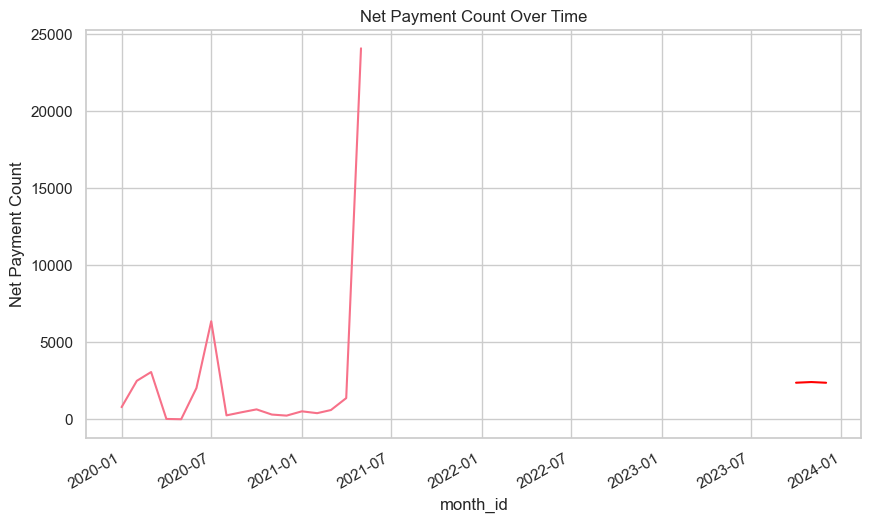

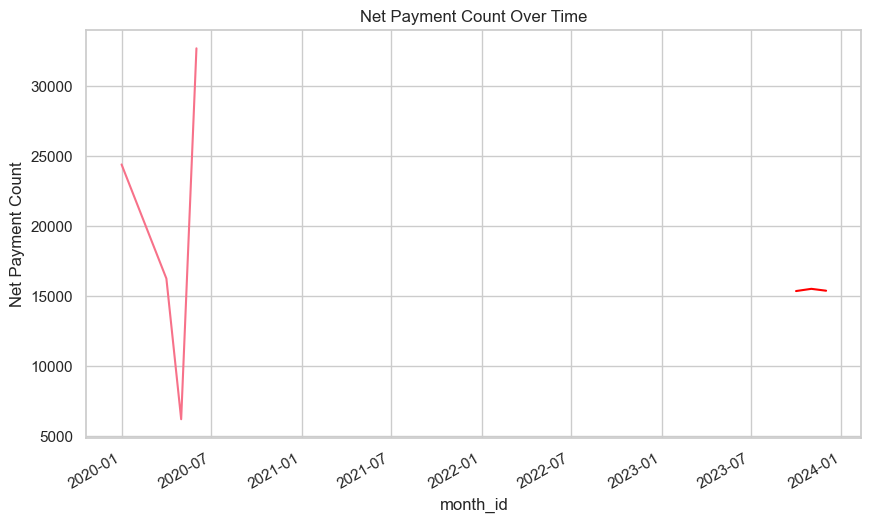

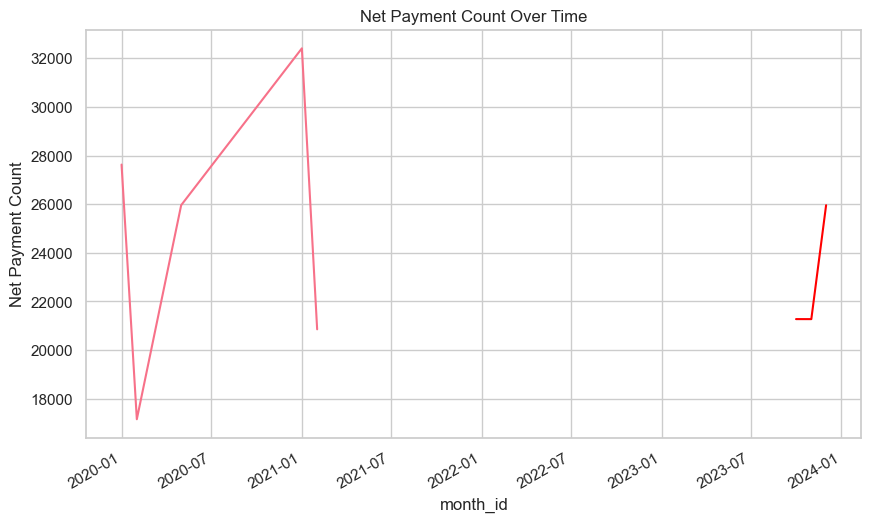

,id,net_payment_count,merchant_id
month_id,,,
2023-11-01,202311merchant_16119,21272.510681,merchant_16119
2023-12-01,202312merchant_16119,25957.159224,merchant_16119
2023-10-01,202310merchant_16119,21273.351306,merchant_16119


In [24]:
plot_payment_count_forecast(filtered_data, test_data, 'merchant_33179')
plot_payment_count_forecast(filtered_data, test_data, 'merchant_41628')
plot_payment_count_forecast(filtered_data, test_data, 'merchant_16119')


In [25]:
# Filter the DataFrame for a specific 'merchant_id'
merchant_id = 'merchant_41628'
df_x = data[data['merchant_id'] == merchant_id]
res_x = filtered_data[filtered_data['merchant_id'] == merchant_id]

# Print specific information for the merchant in the original data
print("Information for merchant", merchant_id, "in original data:")
print("Total number of transactions:", df_x['net_payment_count'].sum())
print("Average transaction amount:", df_x['net_payment_count'].mean())

# Print specific information for the merchant in the filtered data
print("\nInformation for merchant", merchant_id, "in filtered data:")
print("Total number of transactions:", res_x['net_payment_count'].sum())
print("Average transaction amount:", res_x['net_payment_count'].mean())


# Calculate the number of data points for each month_id in the original data
df_monthly_counts = data.groupby('month_id').size()

# Calculate the number of data points for each month_id in the filtered data
filtered_monthly_counts = filtered_data.groupby('month_id').size()

print("Number of data points for each month_id in the original data:")
print(df_monthly_counts)

print("\nNumber of data points for each month_id in the filtered data:")
print(filtered_monthly_counts)


# Filter the DataFrame for the specified merchant_id
df_merchant = data[data['merchant_id'] == merchant_id]
filtered_merchant = filtered_data[filtered_data['merchant_id'] == merchant_id]

# Calculate the number of data points for each month_id in the original data for the specified merchant
df_monthly_counts_merchant = df_merchant.groupby('month_id').size()

# Calculate the number of data points for each month_id in the filtered data for the specified merchant
filtered_monthly_counts_merchant = filtered_merchant.groupby('month_id').size()

print("Number of data points for each month_id in the original data for", merchant_id, ":")
print(df_monthly_counts_merchant)

print("\nNumber of data points for each month_id in the filtered data for", merchant_id, ":")
print(filtered_monthly_counts_merchant)



Information for merchant merchant_41628 in original data:
Total number of transactions: 14314313
Average transaction amount: 318095.84444444446

Information for merchant merchant_41628 in filtered data:
Total number of transactions: 79488
Average transaction amount: 19872.0
Number of data points for each month_id in the original data:
month_id
2020-01-01    3749
2020-02-01    3867
2020-03-01    3951
2020-04-01    4120
2020-05-01    4707
2020-06-01    4920
2020-07-01    4990
2020-08-01    5224
2020-09-01    5489
2020-10-01    5654
2020-11-01    5887
2020-12-01    6352
2021-01-01    6437
2021-02-01    6607
2021-03-01    6883
2021-04-01    6878
2021-05-01    7045
2021-06-01    7004
2021-07-01    6490
2021-08-01    6771
2021-09-01    7021
2021-10-01    7018
2021-11-01    7129
2021-12-01    7413
2022-01-01    7210
2022-02-01    7064
2022-03-01    7332
2022-04-01    7244
2022-05-01    7072
2022-06-01    7040
2022-07-01    6648
2022-08-01    6876
2022-09-01    6967
2022-10-01    7073
2022-11-

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 291142 entries, 2023-07-01 to 2023-09-01
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  object
 1   merchant_source_name  291142 non-null  object
 2   settlement_period     291142 non-null  object
 3   working_type          291142 non-null  object
 4   mcc_id                291142 non-null  object
 5   merchant_segment      291142 non-null  object
 6   net_payment_count     291142 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 17.8+ MB


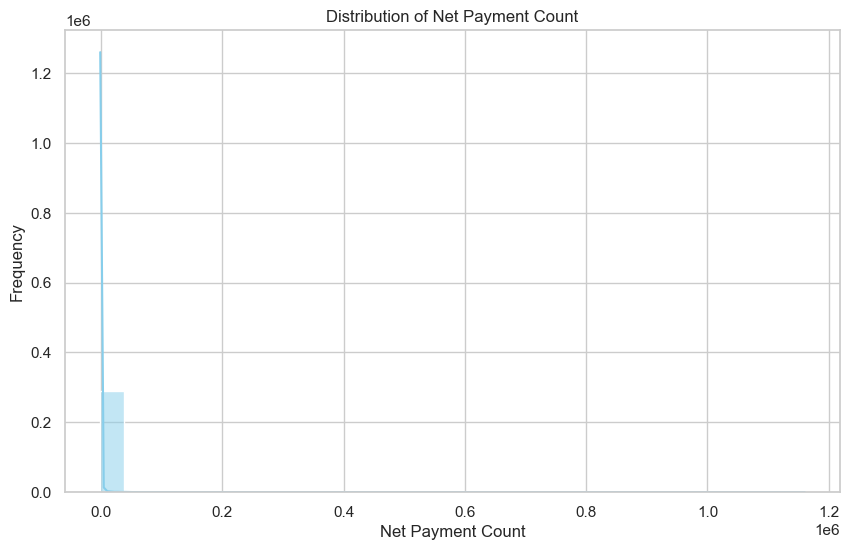

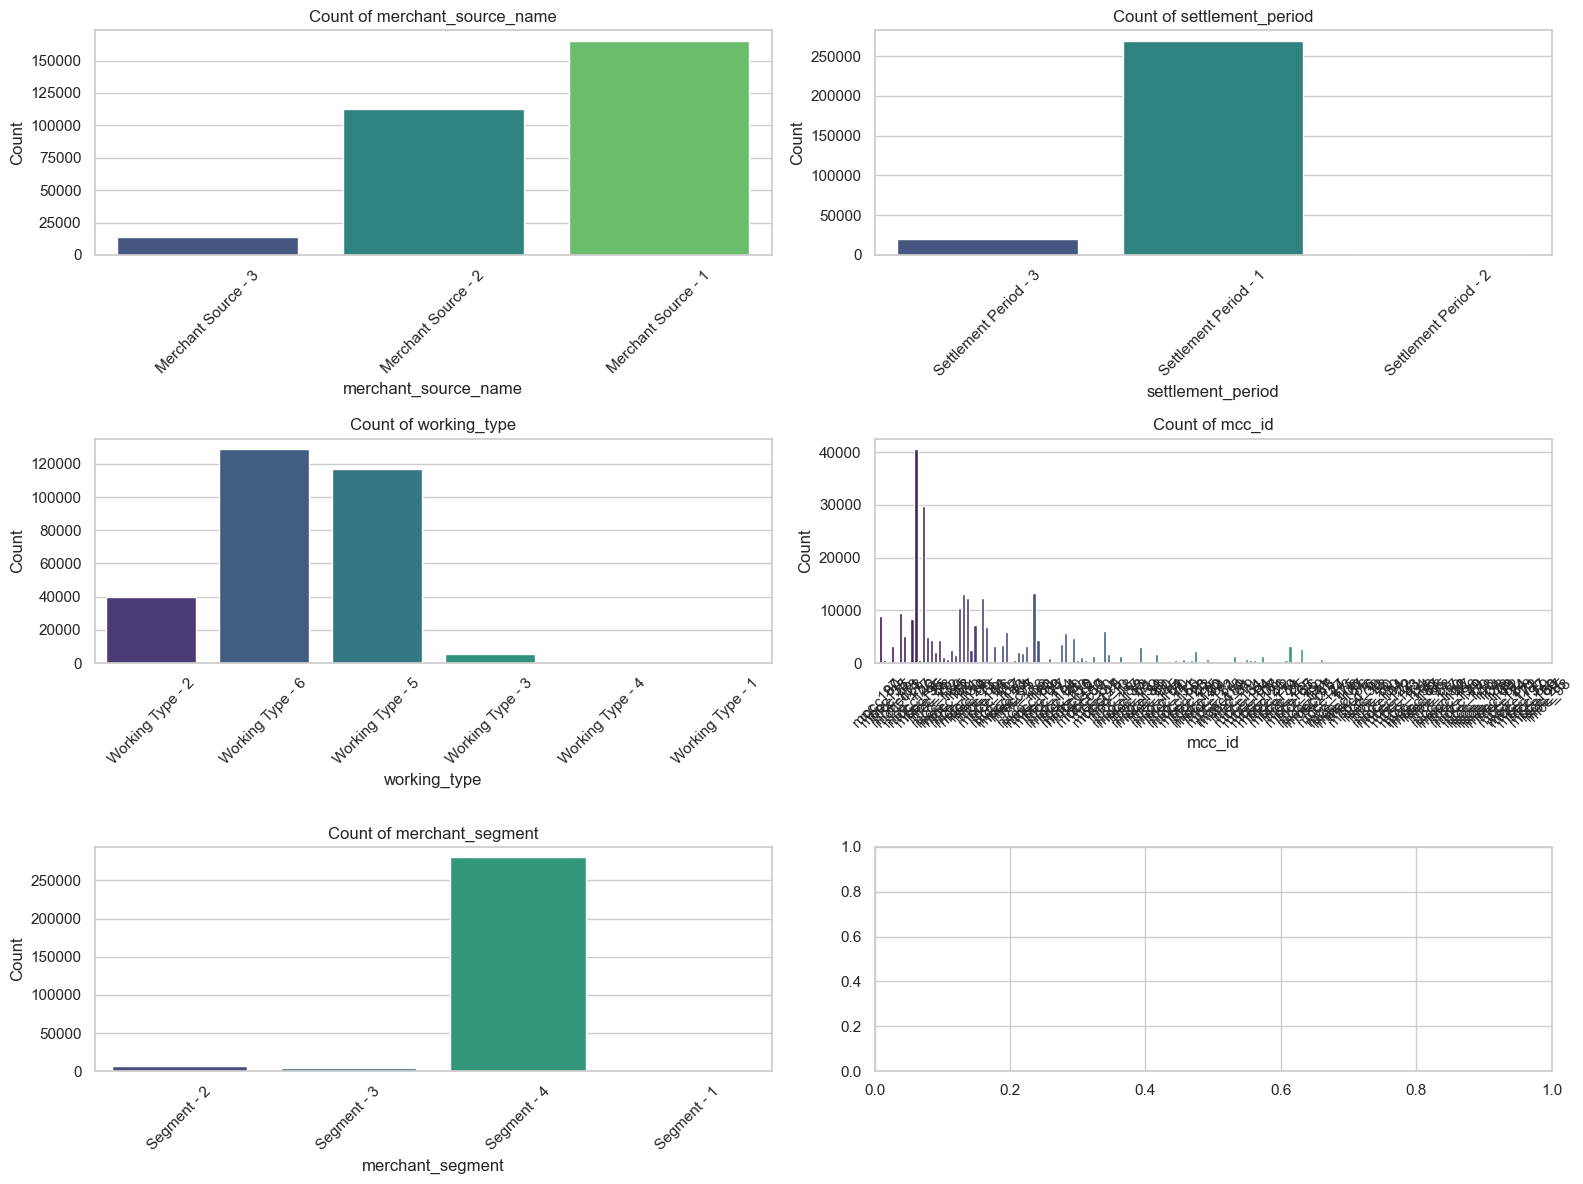

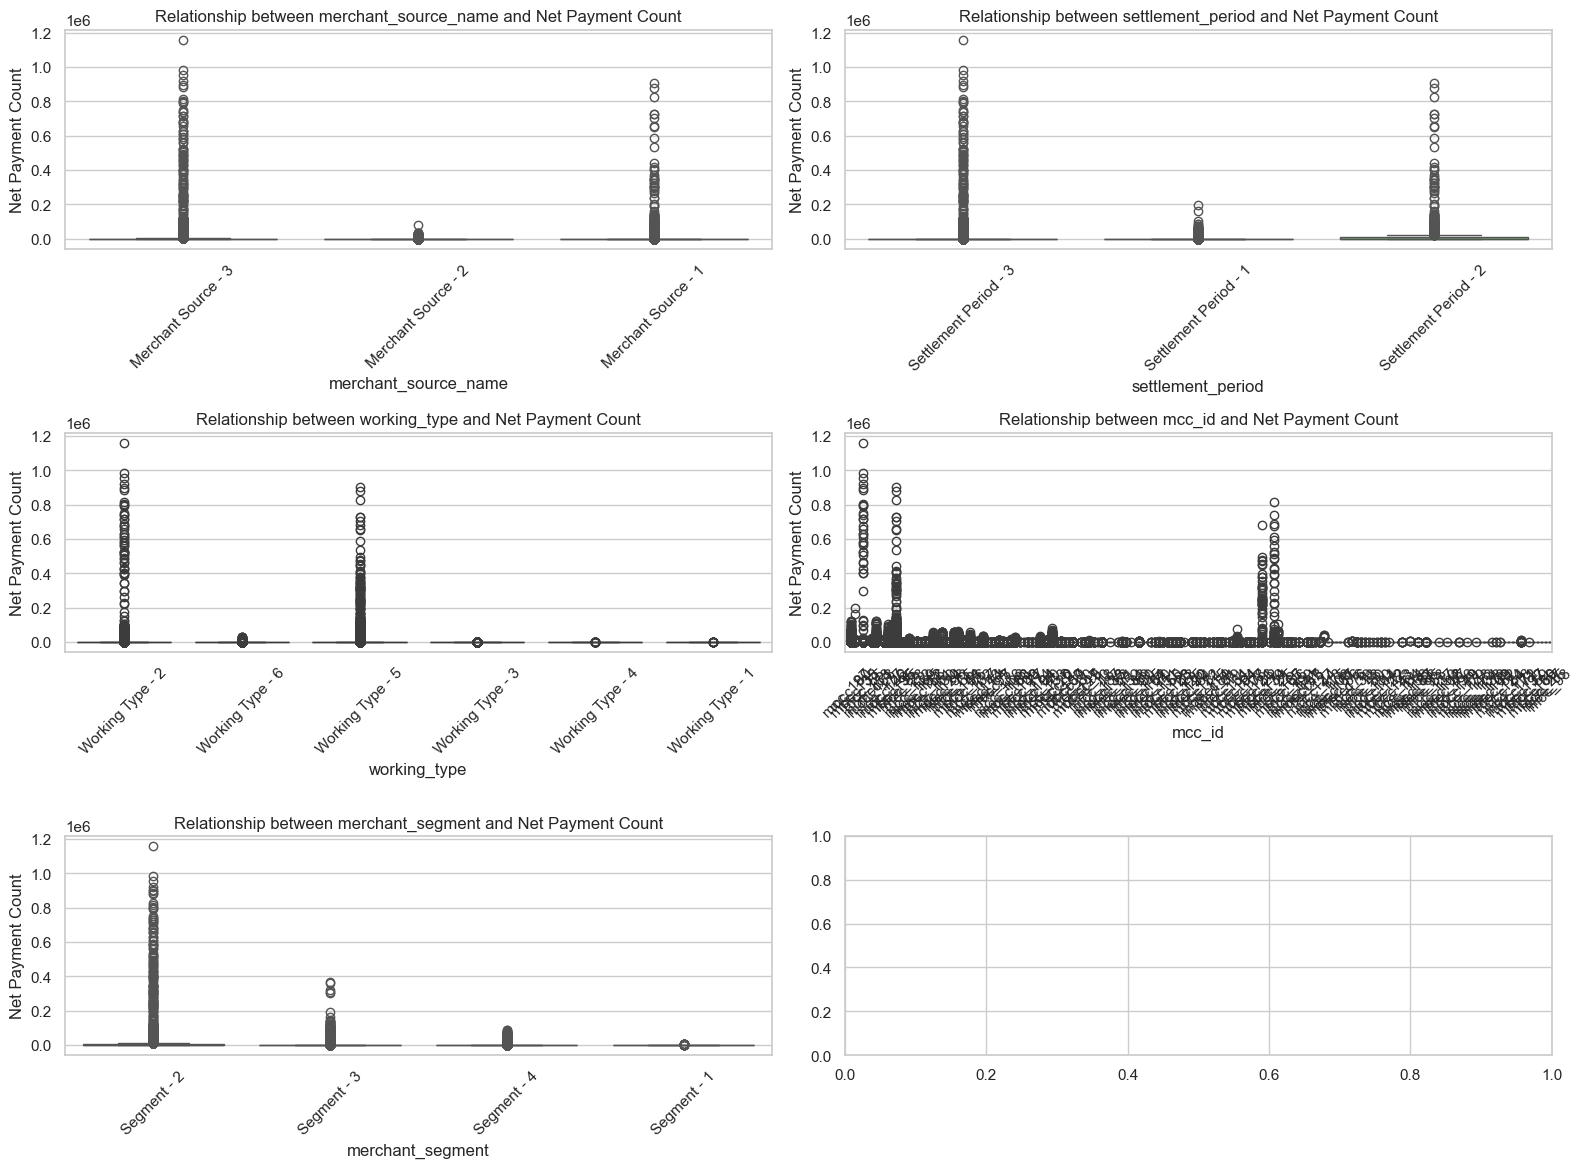

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of net_payment_count
plt.figure(figsize=(10, 6))
sns.histplot(data['net_payment_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Net Payment Count')
plt.xlabel('Net Payment Count')
plt.ylabel('Frequency')
plt.show()

# Plot the count of each categorical variable
categorical_columns = ['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment']
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=data, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Plot the relationship between net_payment_count and each categorical variable
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()
for i, col in enumerate(categorical_columns):
    sns.boxplot(x=col, y='net_payment_count', data=data, ax=axes[i], palette='muted')
    axes[i].set_title(f'Relationship between {col} and Net Payment Count')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Net Payment Count')
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


## Time Series Forecasting with ARIMA:

Split your dataset into training and test sets. Since you have monthly data, you may want to reserve the last few months for testing.
Implement an ARIMA model to forecast the net_payment_count for the test period. Tune the hyperparameters of the ARIMA model to achieve the best performance.
Evaluate the ARIMA model's performance using appropriate metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), etc.

In [28]:
sorted_data = base_train.copy()
sorted_data = sorted_data.sort_values(by=["merchant_id", "month_id"], ascending = True)
sorted_data

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
234370,merchant_1,202108,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
234371,merchant_1,202210,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
249229,merchant_10,202111,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,6
249226,merchant_10,202112,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,24
249224,merchant_10,202201,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,15
...,...,...,...,...,...,...,...,...
277532,merchant_9993,202211,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3
277533,merchant_9993,202212,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3
277531,merchant_9993,202301,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3
277530,merchant_9993,202302,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3


In [29]:
test_data

,id,net_payment_count,merchant_id
month_id,,,
2023-11-01,202311merchant_36004,0,merchant_36004
2023-12-01,202312merchant_36004,0,merchant_36004
2023-10-01,202310merchant_36004,0,merchant_36004
2023-11-01,202311merchant_23099,0,merchant_23099
2023-12-01,202312merchant_23099,0,merchant_23099
...,...,...,...
2023-12-01,202312merchant_35969,0,merchant_35969
2023-10-01,202310merchant_35969,0,merchant_35969
2023-11-01,202311merchant_8429,0,merchant_8429


In [30]:
latest_data = sorted_data.groupby("merchant_id").last()
latest_data

,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
merchant_id,,,,,,,
merchant_1,202210,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3
merchant_10,202204,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,4
merchant_10000,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_5,Segment - 4,4
merchant_10001,202108,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_42,Segment - 4,36
merchant_10002,202210,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_24,Segment - 4,3
...,...,...,...,...,...,...,...
merchant_9984,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_35,Segment - 4,5
merchant_9985,202011,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_168,Segment - 4,4
merchant_9986,202201,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_35,Segment - 4,3


In [31]:
sorted_data[sorted_data["merchant_id"] == "merchant_33179"]

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
96270,merchant_33179,202001,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,787
96260,merchant_33179,202002,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,2499
96283,merchant_33179,202003,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,3070
96261,merchant_33179,202004,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,23
96285,merchant_33179,202005,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,4
96277,merchant_33179,202006,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,2030
96269,merchant_33179,202007,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,6367
96282,merchant_33179,202008,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,255
96262,merchant_33179,202009,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,459
96280,merchant_33179,202010,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_25,Segment - 2,644


In [32]:
sorted_data[['month_id', 'net_payment_count']].corr()

,month_id,net_payment_count
month_id,1.000000,0.006547
net_payment_count,0.006547,1.000000


In [58]:
#transformed_data.drop("mcc_id", axis=1, inplace=True)

# Step 1: Split the Dataset
train_d = transformed_data[transformed_data.index < '2023-07-01']
test_d = transformed_data[transformed_data.index >= '2023-07-01']

# Step 2: Implement ARIMA Model
# Fit ARIMA model
model = ARIMA(train_d['net_payment_count'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast net_payment_count for the test period
forecast = model_fit.forecast(steps=len(test_d))

# Step 3: Evaluate Model Performance
# Calculate MAE and MSE
mae = mean_absolute_error(test_d['net_payment_count'], forecast)
mse = mean_squared_error(test_d['net_payment_count'], forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 926.315372103352
Mean Squared Error (MSE): 205808038.2121661
Root Mean Squared Error (RMSE): 14346.01123003067


In [66]:
# Step 1: Split the Dataset
df_copy = filtered_data.copy()
df_copy.drop("merchant_id", axis=1, inplace=True)

encoding_col_list = ['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']

for i in encoding_col_list:
    df_copy = pd.get_dummies(df_copy, columns=[i], prefix=[i])

train_d = df_copy[df_copy.index < '2023-07-01']
test_d = df_copy[df_copy.index >= '2023-07-01']

# Step 2: Implement ARIMA Model
# Fit ARIMA model
model = ARIMA(train_d['net_payment_count'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast net_payment_count for the test period
forecast = model_fit.forecast(steps=len(test_d))

# Step 3: Evaluate Model Performance
# Calculate MAE and MSE
mae = mean_absolute_error(test_d['net_payment_count'], forecast)
mse = mean_squared_error(test_d['net_payment_count'], forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 120.72572021251814
Mean Squared Error (MSE): 1202465.9987345801
Root Mean Squared Error (RMSE): 1096.5701066209037


In [78]:
df_copy = base_train.copy()

df_copy['month_id'] = pd.to_datetime(df_copy['month_id'], format='%Y%m')
df_copy.set_index('month_id', inplace=True)
df_copy

df_copy.drop("mcc_id", axis=1, inplace=True)

encoding_df = df_copy[['merchant_id', 'merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']]
scale_df = df_copy[['net_payment_count']]

df_copy

,merchant_id,merchant_source_name,settlement_period,working_type,merchant_segment,net_payment_count
month_id,,,,,,
2023-07-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,15106
2023-01-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,16918
2023-05-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,13452
2023-08-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,16787
2023-02-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,Segment - 2,12428
...,...,...,...,...,...,...
2023-09-01,merchant_67083,Merchant Source - 1,Settlement Period - 1,Working Type - 6,Segment - 4,4
2023-09-01,merchant_4263,Merchant Source - 2,Settlement Period - 1,Working Type - 6,Segment - 4,4
2023-09-01,merchant_11346,Merchant Source - 1,Settlement Period - 1,Working Type - 6,Segment - 4,3


In [79]:
encoding_col_list = ['merchant_source_name', 'settlement_period', 'working_type', 'merchant_segment']

for i in encoding_col_list:
    df_copy = pd.get_dummies(df_copy, columns=[i], prefix=[i])
                     
df_copy

,merchant_id,net_payment_count,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4
month_id,,,,,,,,,,,,,,,,,,
2023-07-01,merchant_43992,15106,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
2023-01-01,merchant_43992,16918,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
2023-05-01,merchant_43992,13452,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
2023-08-01,merchant_43992,16787,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
2023-02-01,merchant_43992,12428,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,merchant_67083,4,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
2023-09-01,merchant_4263,4,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,True
2023-09-01,merchant_11346,3,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True


In [80]:
lbe = LabelEncoder()
df_copy['merchant_id'] = lbe.fit_transform(df_copy['merchant_id'])

df_copy = df_copy.astype('int64')
df_copy

,merchant_id,net_payment_count,merchant_source_name_Merchant Source - 1,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 1,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,working_type_Working Type - 1,working_type_Working Type - 2,working_type_Working Type - 3,working_type_Working Type - 4,working_type_Working Type - 5,working_type_Working Type - 6,merchant_segment_Segment - 1,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4
month_id,,,,,,,,,,,,,,,,,,
2023-07-01,14423,15106,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
2023-01-01,14423,16918,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
2023-05-01,14423,13452,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
2023-08-01,14423,16787,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
2023-02-01,14423,12428,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,24345,4,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2023-09-01,13856,4,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2023-09-01,614,3,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


In [96]:
df_copy = df_copy.sort_values(["month_id", "merchant_id"])
df_copy

"""
train_d = df_copy[df_copy.index < '2023-07-01']
test_d = df_copy[df_copy.index >= '2023-07-01']


X_train = train_d.drop(columns=['net_payment_count'])
y_train = train_d['net_payment_count']
X_test = test_d.drop(columns=['net_payment_count'])
y_test = test_d['net_payment_count']"""

x = df_copy.drop("net_payment_count", axis=1)
y = df_copy[["net_payment_count"]]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)



In [97]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)
knn_model

KNeighborsRegressor()

In [98]:
knn_model.n_neighbors

5

In [99]:
knn_model.effective_metric_


'euclidean'

In [100]:
y_pred = knn_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

269.0388500575315

In [51]:
transformed_data

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
month_id,,,,,,,
2020-01-01,merchant_48325,42.569024,55.340992,328.043860,456.089459,40.612028,5
2020-01-01,merchant_15886,63.243291,55.340992,7.502470,792.096210,40.612028,3
2020-01-01,merchant_31247,42.569024,55.340992,664.178335,298.773607,40.612028,22
2020-01-01,merchant_67022,63.243291,55.340992,27.007557,219.242740,40.612028,14
2020-01-01,merchant_24293,42.569024,55.340992,328.043860,102.992301,40.612028,8
...,...,...,...,...,...,...,...
2023-09-01,merchant_48159,499.735014,30727.894470,983.438937,587.668176,100.730134,210
2023-09-01,merchant_40681,499.735014,102.729253,45.356942,237.947884,100.730134,10
2023-09-01,merchant_56097,499.735014,102.729253,983.438937,59.561611,100.730134,4


In [49]:
filtered_data

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
month_id,,,,,,,
2023-07-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
2023-01-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2023-05-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
2023-08-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
2023-02-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...
2023-09-01,merchant_67083,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
2023-09-01,merchant_4263,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
2023-09-01,merchant_11346,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3


In [ ]:

df = base_train.copy()
res = sample_submission.copy()
res[['month_id', 'merchant_id']] = res['id'].str.extract(r'(\d{6})(merchant_\d+)')
df_sorted = df.sort_values(by=['merchant_id', 'month_id'], ascending=[True, False])

# Group by 'merchant_id' and keep the first row of each group
latest_data = df_sorted.groupby('merchant_id').first().reset_index()

result = pd.merge(res, latest_data, on='merchant_id', how="left")
result.loc[(result['net_payment_count_y'] < 1) | (result['month_id_y'] < 202309), 'net_payment_count_x'] = 0
result.loc[~((result['net_payment_count_y'] < 1) | (result['month_id_y'] < 202309)), 'net_payment_count_x'] = result['net_payment_count_y']
columns_to_keep = ['id', 'net_payment_count_x']
result = result[columns_to_keep]

# Rename 'net_payment_count_x' to 'net_payment_count'
result = result.rename(columns={'net_payment_count_x': 'net_payment_count'})

# Save to CSV to submit
"""result.to_csv('submitleBeni.csv', index=False)='left')"""
result.sort_values("net_payment_count")

## Feature Engineering:

Utilize the additional columns (merchant_source, settlement_period, working_type, mcc_id, merchant_segment) to engineer new features that could potentially improve your model's performance.
Consider creating lag features, rolling window statistics, or any other relevant transformations based on domain knowledge or insights gained from EDA.

## Model Building:

Incorporate the engineered features into your dataset and split it into training and test sets.
Choose an appropriate machine learning model (e.g., RandomForest, Gradient Boosting, Neural Networks) to train on the dataset.
Perform hyperparameter tuning using techniques like grid search or random search to optimize the model's performance.
Evaluate the model using appropriate evaluation metrics and compare it with the ARIMA model's performance.

In [45]:
sorted_data_by_month = sorted_data.sort_values(by='month_id')
sorted_data_by_month

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
39020,merchant_48325,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_20,Segment - 4,5
100041,merchant_15886,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 3,mcc_80,Segment - 4,3
86856,merchant_31247,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 2,mcc_35,Segment - 4,22
81952,merchant_67022,202001,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_144,Segment - 4,14
103759,merchant_24293,202001,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_130,Segment - 4,8
...,...,...,...,...,...,...,...,...
282483,merchant_48159,202309,Merchant Source - 1,Settlement Period - 2,Working Type - 5,mcc_49,Segment - 4,210
14875,merchant_40681,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,10
264970,merchant_56097,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 5,mcc_106,Segment - 4,4
41365,merchant_48177,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_162,Segment - 4,3


In [55]:
#using target encoding
import category_encoders as ce

# Read the data sorted by date
data_encode = sorted_data.copy()
data_encode = data_encode.sort_values(by='month_id')

# Initialize the target encoder
encoder = ce.TargetEncoder(cols=['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment'])

# Initialize an empty DataFrame to store transformed data
transformed_data = pd.DataFrame()

# Iterate over each batch of data
for idx, batch in data_encode.groupby(data_encode['month_id']):
    # Update the target encoding using the current batch of data
    encoder.fit(batch, batch['net_payment_count'])
    # Transform the data with the updated target encoding and append to transformed_data
    transformed_batch = encoder.transform(batch)
    transformed_data = pd.concat([transformed_data, transformed_batch])


In [41]:
#using catboost
import category_encoders as ce

# Read the data sorted by date
data_encode = sorted_data.copy()
data_encode = data_encode.sort_values(by='month_id')

# Initialize the CatBoost encoder
encoder = ce.CatBoostEncoder(cols=['merchant_source_name', 'settlement_period', 'working_type', 'mcc_id', 'merchant_segment'])

# Initialize an empty DataFrame to store transformed data
transformed_data = pd.DataFrame()

# Iterate over each batch of data
for idx, batch in data_encode.groupby(data_encode['month_id']):
    # Update the CatBoost encoding using the current batch of data
    encoder.fit(batch, batch['net_payment_count'])
    # Transform the data with the updated CatBoost encoding and append to transformed_data
    transformed_batch = encoder.transform(batch)
    transformed_data = pd.concat([transformed_data, transformed_batch])


In [56]:
# Set 'month_id' as the index for the transformed data
transformed_data['month_id'] = pd.to_datetime(transformed_data['month_id'], format='%Y%m')
transformed_data.set_index('month_id', inplace=True)

#transformed_data = pd.get_dummies(transformed_data, columns=['merchant_id'])

In [57]:
transformed_data

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
month_id,,,,,,,
2020-01-01,merchant_48325,42.464286,55.298745,328.129972,458.385158,40.566585,5
2020-01-01,merchant_15886,63.171657,55.298745,5.850790,795.277130,40.566585,3
2020-01-01,merchant_31247,42.464286,55.298745,665.333333,299.094077,40.566585,22
2020-01-01,merchant_67022,63.171657,55.298745,26.909041,219.338252,40.566585,14
2020-01-01,merchant_24293,42.464286,55.298745,328.129972,102.322724,40.566585,8
...,...,...,...,...,...,...,...
2023-09-01,merchant_48159,499.713697,30630.619012,983.573370,538.530346,100.659296,210
2023-09-01,merchant_40681,499.713697,102.655035,45.180695,236.671533,100.659296,10
2023-09-01,merchant_56097,499.713697,102.655035,983.573370,54.198410,100.659296,4


In [ ]:
# Split the data into training and test sets based on the specified date
train_d = transformed_data[transformed_data.index < '2023-07']
test_d = transformed_data[transformed_data.index >= '2023-07']

# Split the training and test sets into features (X) and target variable (y)
X_train = train_d.drop(columns=['net_payment_count'])
y_train = train_d['net_payment_count']
X_test = test_d.drop(columns=['net_payment_count'])
y_test = test_d['net_payment_count']

# Initialize and train your model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = model.predict(X_test)

# Evaluate the model on the test set
mse_test = mean_squared_error(y_test, y_pred_test)
print("Test Mean Squared Error:", mse_test)

In [214]:
X_train.merchant_id

month_id
2020-01-01    merchant_48325
2020-01-01    merchant_15886
2020-01-01    merchant_31247
2020-01-01    merchant_67022
2020-01-01    merchant_24293
                   ...      
2023-06-01    merchant_40615
2023-06-01    merchant_61693
2023-06-01    merchant_61617
2023-06-01    merchant_39079
2023-06-01    merchant_39127
Name: merchant_id, Length: 269323, dtype: object

## Model Evaluation and Selection:

Compare the performance of the ARIMA model and the machine learning model based on evaluation metrics such as MAE, MSE, etc.
Select the model that provides the best performance on the test set.

## Model Deployment and Monitoring:

Once you have selected the final model, deploy it into your production environment.
Monitor the model's performance over time and retrain it periodically with new data if necessary.
Continuously evaluate and iterate on your model to maintain its effectiveness.

## Documentation and Reporting:

Document all the steps taken in your project, including data preprocessing, model building, evaluation results, and any insights gained.
Prepare a report summarizing your findings, methodology, and recommendations for stakeholders.

In [3]:
new_data = base_train.copy()
new_data

,merchant_id,month_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
0,merchant_43992,202307,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
1,merchant_43992,202301,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2,merchant_43992,202305,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
3,merchant_43992,202308,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
4,merchant_43992,202302,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...,...
291137,merchant_67083,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
291138,merchant_4263,202309,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
291139,merchant_11346,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3
291140,merchant_21397,202309,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_168,Segment - 4,3


In [4]:
new_data['month_id'] = pd.to_datetime(new_data['month_id'], format='%Y%m')
new_data.set_index('month_id', inplace=True)
new_data

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count
month_id,,,,,,,
2023-07-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106
2023-01-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918
2023-05-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452
2023-08-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787
2023-02-01,merchant_43992,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428
...,...,...,...,...,...,...,...
2023-09-01,merchant_67083,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4
2023-09-01,merchant_4263,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4
2023-09-01,merchant_11346,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3


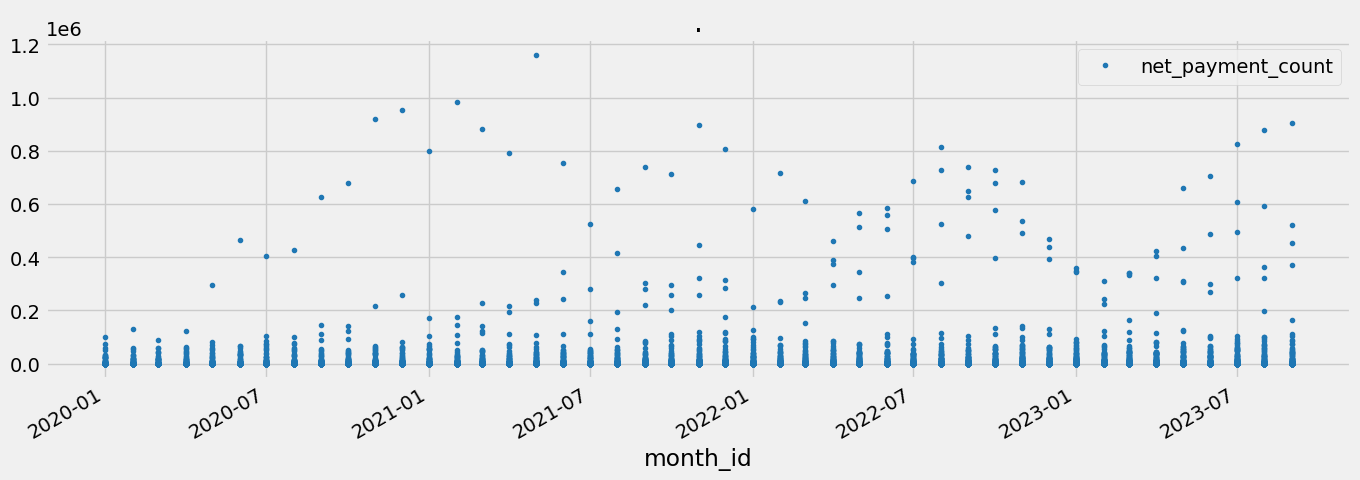

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

new_data.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='.')
plt.show()

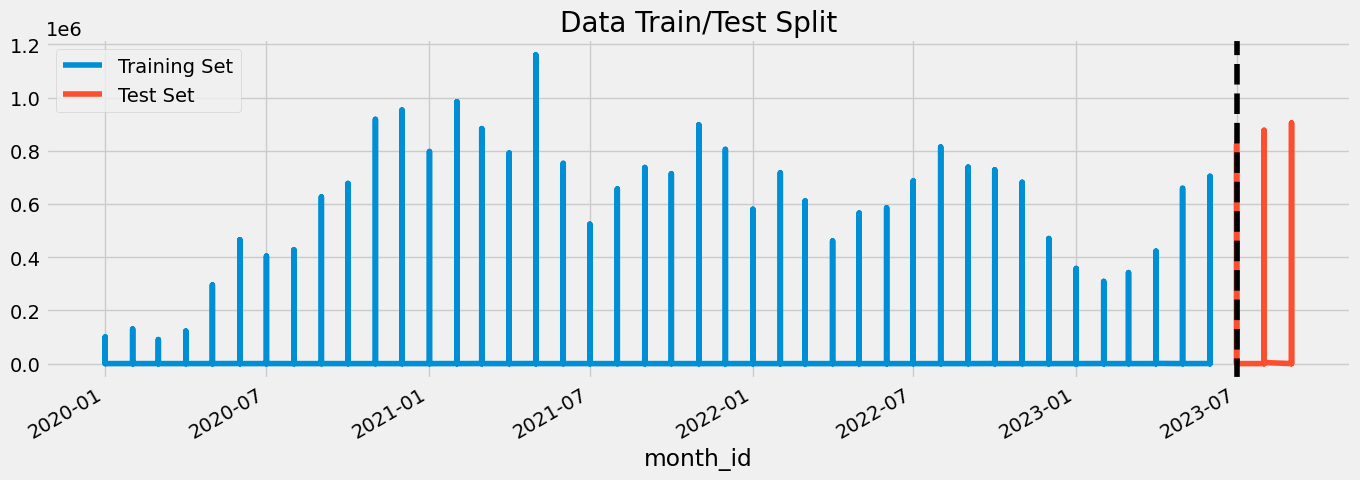

In [6]:
train = new_data.loc[new_data.index < '2023-07-01']
test = new_data.loc[new_data.index >= '2023-07-01']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('2023-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

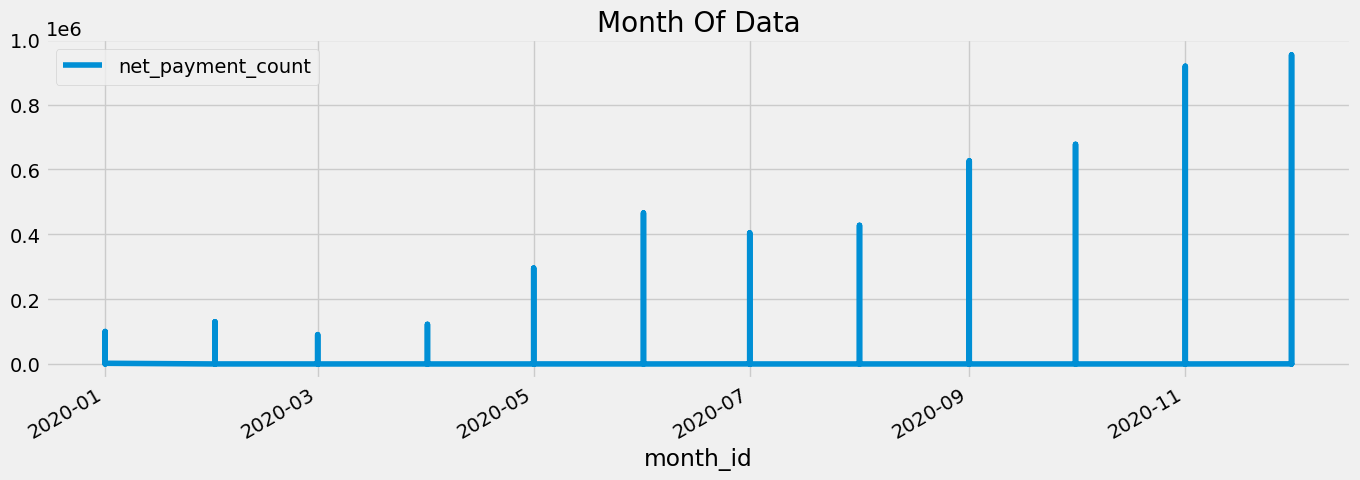

In [7]:
new_data.loc[(new_data.index >= '2020-01-01') & (new_data.index < '2021-01-01')] \
    .plot(figsize=(15, 5), title='Month Of Data')
plt.show()

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    # Add a column to represent summer solstice for the entire month
    df['summer_solstice'] = (df['month'] == 6).astype(int)  # June

    # Add a column to represent Black Friday for the entire month of November
    df['black_friday'] = (df['month'] == 11).astype(int)  # November
    


    return df

df = create_features(new_data)
lbe = LabelEncoder()
df['merchant_id'] = lbe.fit_transform(df['merchant_id'])

In [9]:
df

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday
month_id,,,,,,,,,,,,,,,
2023-07-01,14423,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,15106,5,3,7,2023,182,26,0,0
2023-01-01,14423,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16918,6,1,1,2023,1,52,0,0
2023-05-01,14423,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,13452,0,2,5,2023,121,18,0,0
2023-08-01,14423,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,16787,1,3,8,2023,213,31,0,0
2023-02-01,14423,Merchant Source - 3,Settlement Period - 3,Working Type - 2,mcc_197,Segment - 2,12428,2,1,2,2023,32,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-01,24345,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,4,4,3,9,2023,244,35,0,0
2023-09-01,13856,Merchant Source - 2,Settlement Period - 1,Working Type - 6,mcc_73,Segment - 4,4,4,3,9,2023,244,35,0,0
2023-09-01,614,Merchant Source - 1,Settlement Period - 1,Working Type - 6,mcc_169,Segment - 4,3,4,3,9,2023,244,35,0,0


In [10]:
df = df.sort_values(["merchant_id", "month_id"])
df

,merchant_id,merchant_source_name,settlement_period,working_type,mcc_id,merchant_segment,net_payment_count,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday
month_id,,,,,,,,,,,,,,,
2021-08-01,0,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3,6,3,8,2021,213,30,0,0
2022-10-01,0,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_128,Segment - 4,3,5,4,10,2022,274,39,0,0
2021-11-01,1,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,6,0,4,11,2021,305,44,0,1
2021-12-01,1,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,24,2,4,12,2021,335,48,0,0
2022-01-01,1,Merchant Source - 2,Settlement Period - 3,Working Type - 6,mcc_42,Segment - 4,15,5,1,1,2022,1,52,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,26059,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3,1,4,11,2022,305,44,0,1
2022-12-01,26059,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3,3,4,12,2022,335,48,0,0
2023-01-01,26059,Merchant Source - 2,Settlement Period - 1,Working Type - 5,mcc_132,Segment - 4,3,6,1,1,2023,1,52,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 291142 entries, 2021-08-01 to 2023-06-01
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   merchant_id           291142 non-null  int64 
 1   merchant_source_name  291142 non-null  object
 2   settlement_period     291142 non-null  object
 3   working_type          291142 non-null  object
 4   mcc_id                291142 non-null  object
 5   merchant_segment      291142 non-null  object
 6   net_payment_count     291142 non-null  int64 
 7   dayofweek             291142 non-null  int32 
 8   quarter               291142 non-null  int32 
 9   month                 291142 non-null  int32 
 10  year                  291142 non-null  int32 
 11  dayofyear             291142 non-null  int32 
 12  weekofyear            291142 non-null  UInt32
 13  summer_solstice       291142 non-null  int64 
 14  black_friday          291142 non-null  int64 
dtypes

In [12]:
df.drop("mcc_id" , axis=1, inplace=True)
df.drop("working_type" , axis=1, inplace=True)

df = pd.get_dummies(df, columns= ["merchant_segment", "merchant_source_name", "settlement_period"], drop_first=True)  # One-hot encode categorical variables if necessary

In [13]:
df = df.astype('int64')
#df['net_payment_count'] = np.log1p(df['net_payment_count'])
train = df.loc[df.index < '2023-04-01']
test = df.loc[df.index >= '2023-04-01']

df

,merchant_id,net_payment_count,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
month_id,,,,,,,,,,,,,,,,,
2021-08-01,0,3,6,3,8,2021,213,30,0,0,0,0,1,1,0,0,0
2022-10-01,0,3,5,4,10,2022,274,39,0,0,0,0,1,1,0,0,0
2021-11-01,1,6,0,4,11,2021,305,44,0,1,0,0,1,1,0,0,1
2021-12-01,1,24,2,4,12,2021,335,48,0,0,0,0,1,1,0,0,1
2022-01-01,1,15,5,1,1,2022,1,52,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-01,26059,3,1,4,11,2022,305,44,0,1,0,0,1,1,0,0,0
2022-12-01,26059,3,3,4,12,2022,335,48,0,0,0,0,1,1,0,0,0
2023-01-01,26059,3,6,1,1,2023,1,52,0,0,0,0,1,1,0,0,0


ValueError: Could not interpret value `index` for `x`. An entry with this name does not appear in `data`.

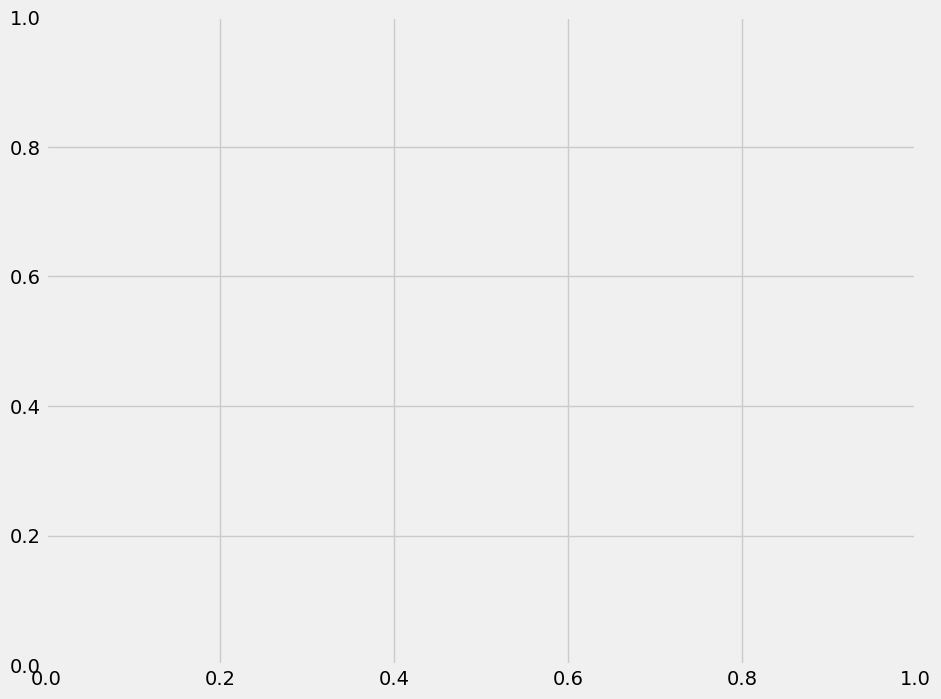

In [14]:
# Reset the index
df_reset = df.reset_index()

# Plot the boxplot
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_reset, x='index', y='log_net_payment_count', ax=ax)
ax.set_title('NPC by Month')
plt.xlabel('Month')
plt.ylabel('Log Net Payment Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='dayofweek', y='net_payment_count')
ax.set_title('NPC by Day of Week')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='quarter', y='net_payment_count')
ax.set_title('NPC by quarter')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='net_payment_count')
ax.set_title('NPC by month')
plt.show()

In [15]:
train

,merchant_id,net_payment_count,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
month_id,,,,,,,,,,,,,,,,,
2021-08-01,0,3,6,3,8,2021,213,30,0,0,0,0,1,1,0,0,0
2022-10-01,0,3,5,4,10,2022,274,39,0,0,0,0,1,1,0,0,0
2021-11-01,1,6,0,4,11,2021,305,44,0,1,0,0,1,1,0,0,1
2021-12-01,1,24,2,4,12,2021,335,48,0,0,0,0,1,1,0,0,1
2022-01-01,1,15,5,1,1,2022,1,52,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-01,26059,8,5,4,10,2022,274,39,0,0,0,0,1,1,0,0,0
2022-11-01,26059,3,1,4,11,2022,305,44,0,1,0,0,1,1,0,0,0
2022-12-01,26059,3,3,4,12,2022,335,48,0,0,0,0,1,1,0,0,0


In [16]:
train = create_features(train)
test = create_features(test)


"""FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year', 'merchant_source_name', 'settlement_period', 'working_type','merchant_segment']
TARGET = 'net_payment_count'"""


X_train = train.drop(columns=['net_payment_count'])
y_train = train['net_payment_count']

X_test = test.drop(columns=['net_payment_count'])
y_test = test['net_payment_count']

"""X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]"""

'X_train = train[FEATURES]\ny_train = train[TARGET]\n\nX_test = test[FEATURES]\ny_test = test[TARGET]'

In [17]:
X_test

,merchant_id,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
month_id,,,,,,,,,,,,,,,,
2023-04-01,2,5,2,4,2023,91,13,0,0,0,0,1,1,0,0,0
2023-05-01,2,0,2,5,2023,121,18,0,0,0,0,1,1,0,0,0
2023-06-01,2,3,2,6,2023,152,22,1,0,0,0,1,1,0,0,0
2023-08-01,2,1,3,8,2023,213,31,0,0,0,0,1,1,0,0,0
2023-09-01,2,4,3,9,2023,244,35,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,26058,3,2,6,2023,152,22,1,0,0,0,1,0,0,0,0
2023-07-01,26058,5,3,7,2023,182,26,0,0,0,0,1,0,0,0,0
2023-08-01,26058,1,3,8,2023,213,31,0,0,0,0,1,0,0,0,0


In [18]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:10457.26386	validation_1-rmse:12607.70706
[100]	validation_0-rmse:9263.61564	validation_1-rmse:12162.68904
[200]	validation_0-rmse:8950.88923	validation_1-rmse:11949.77527
[300]	validation_0-rmse:8669.64575	validation_1-rmse:11552.81864
[400]	validation_0-rmse:8417.15577	validation_1-rmse:10962.71101
[500]	validation_0-rmse:8333.98331	validation_1-rmse:10781.04714
[600]	validation_0-rmse:8227.48970	validation_1-rmse:10735.85852
[627]	validation_0-rmse:8210.45393	validation_1-rmse:10750.45344


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

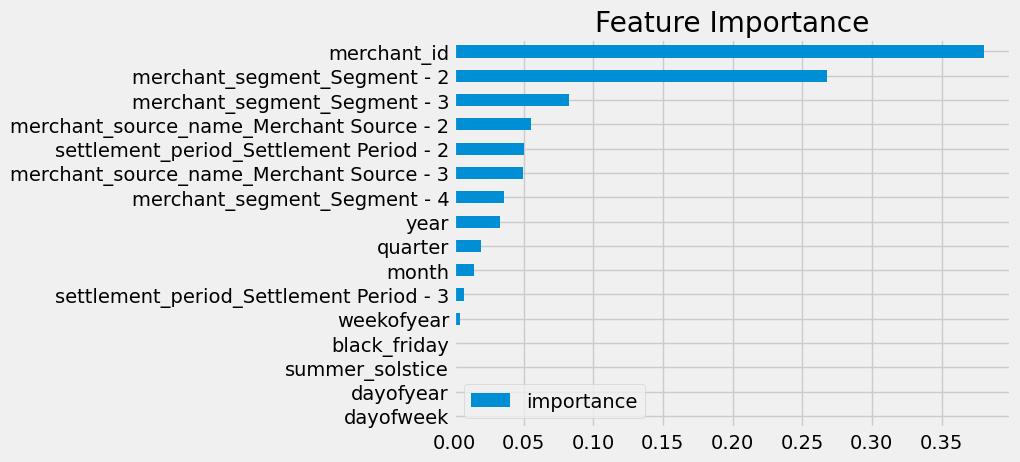

In [19]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [20]:
X_test

,merchant_id,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3
month_id,,,,,,,,,,,,,,,,
2023-04-01,2,5,2,4,2023,91,13,0,0,0,0,1,1,0,0,0
2023-05-01,2,0,2,5,2023,121,18,0,0,0,0,1,1,0,0,0
2023-06-01,2,3,2,6,2023,152,22,1,0,0,0,1,1,0,0,0
2023-08-01,2,1,3,8,2023,213,31,0,0,0,0,1,1,0,0,0
2023-09-01,2,4,3,9,2023,244,35,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,26058,3,2,6,2023,152,22,1,0,0,0,1,0,0,0,0
2023-07-01,26058,5,3,7,2023,182,26,0,0,0,0,1,0,0,0,0
2023-08-01,26058,1,3,8,2023,213,31,0,0,0,0,1,0,0,0,0


In [21]:
test['prediction'] = reg.predict(X_test)

In [22]:
test

,merchant_id,net_payment_count,dayofweek,quarter,month,year,dayofyear,weekofyear,summer_solstice,black_friday,merchant_segment_Segment - 2,merchant_segment_Segment - 3,merchant_segment_Segment - 4,merchant_source_name_Merchant Source - 2,merchant_source_name_Merchant Source - 3,settlement_period_Settlement Period - 2,settlement_period_Settlement Period - 3,prediction
month_id,,,,,,,,,,,,,,,,,,
2023-04-01,2,4,5,2,4,2023,91,13,0,0,0,0,1,1,0,0,0,46.539764
2023-05-01,2,6,0,2,5,2023,121,18,0,0,0,0,1,1,0,0,0,46.539764
2023-06-01,2,4,3,2,6,2023,152,22,1,0,0,0,1,1,0,0,0,46.539764
2023-08-01,2,3,1,3,8,2023,213,31,0,0,0,0,1,1,0,0,0,46.539764
2023-09-01,2,4,4,3,9,2023,244,35,0,0,0,0,1,1,0,0,0,46.539764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,26058,10,3,2,6,2023,152,22,1,0,0,0,1,0,0,0,0,-23.000372
2023-07-01,26058,15,5,3,7,2023,182,26,0,0,0,0,1,0,0,0,0,-23.000372
2023-08-01,26058,9,1,3,8,2023,213,31,0,0,0,0,1,0,0,0,0,-23.000372


In [23]:
"""df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['net_payment_count']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()"""

"df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)\nax = df[['net_payment_count']].plot(figsize=(15, 5))\ndf['prediction'].plot(ax=ax, style='.')\nplt.legend(['Truth Data', 'Predictions'])\nax.set_title('Raw Dat and Prediction')\nplt.show()"

In [24]:
"""ax = df.loc[(df.index > '2020-01-01') & (df.index < '2020-09-01')]['net_payment_count'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '2020-01-01') & (df.index < '2020-09-01')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()"""

"ax = df.loc[(df.index > '2020-01-01') & (df.index < '2020-09-01')]['net_payment_count']     .plot(figsize=(15, 5), title='Week Of Data')\ndf.loc[(df.index > '2020-01-01') & (df.index < '2020-09-01')]['prediction']     .plot(style='.')\nplt.legend(['Truth Data','Prediction'])\nplt.show()"

In [25]:
score = np.sqrt(mean_squared_error(test['net_payment_count'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 10699.35


In [26]:
score = (mean_absolute_error(test['net_payment_count'], test['prediction']))
print(f'MAE Score on Test set: {score:0.2f}')

MAE Score on Test set: 750.98


knn

In [27]:
knn_model = KNeighborsRegressor().fit(X_train, y_train)
knn_model

KNeighborsRegressor()

In [28]:
knn_model.n_neighbors


5

In [29]:
y_pred = knn_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

657.2263766646699

In [30]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

cart_model = DecisionTreeRegressor(min_samples_split = 2)
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [31]:
y_pred =cart_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

303.1852218791761

In [32]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

In [33]:
bag_model.n_estimators


10

In [34]:
y_pred = bag_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

555.3580740128067

In [35]:
from sklearn.model_selection import GridSearchCV, cross_val_score

bag_params = {"n_estimators": range(2,20)}
bag_cv_model = GridSearchCV(bag_model, bag_params, cv = 10)
bag_cv_model.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=BaggingRegressor(bootstrap_features=True),
             param_grid={'n_estimators': range(2, 20)})

In [36]:
bag_cv_model.best_params_


{'n_estimators': 17}

In [37]:
bag_tuned_model = BaggingRegressor(n_estimators = 8, random_state = 45)
bag_tuned_model.fit(X_train, y_train)

BaggingRegressor(n_estimators=8, random_state=45)

In [38]:
y_pred = bag_tuned_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

309.41304836182667

In [39]:
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [40]:
y_pred = rf_model.predict(X_test)
mean_absolute_error(y_test, y_pred)

313.9430321183355

Text(0.5, 0, 'Değişken Önem Düzeyleri')

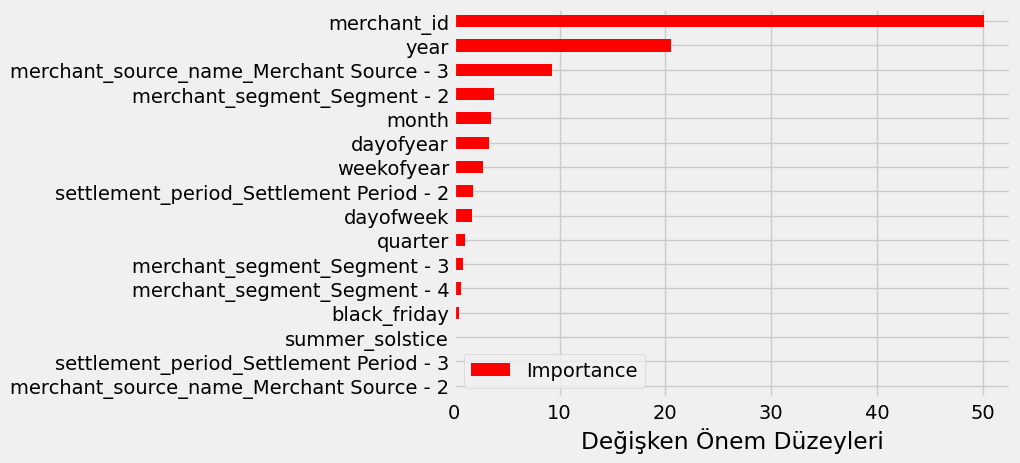

In [155]:
Importance = pd.DataFrame({"Importance": rf_model.feature_importances_*100},
                         index = X_train.columns)
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")
plt.xlabel("Değişken Önem Düzeyleri")

In [ ]:
Importance = pd.DataFrame({"Importance": rf_model.feature_importances_*100},
                         index = X_train.columns)
Importance.sort_values(by = "Importance", 
                       axis = 0, 
                       ascending = True).plot(kind ="barh", color = "r")
plt.xlabel("Değişken Önem Düzeyleri")

In [85]:
models = [
    knn_model,
    cart_model,
    bag_model,
    bag_tuned_model,
    rf_model,
]

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print("-"*28)
    print(names + ":" )
    print("Mean Absolute Error: {}".format(mae))

----------------------------
KNeighborsRegressor:
Mean Absolute Error: 717.622393326917
----------------------------
DecisionTreeRegressor:
Mean Absolute Error: 194.0523855355424
----------------------------
BaggingRegressor:
Mean Absolute Error: 590.2273780911596
----------------------------
BaggingRegressor:
Mean Absolute Error: 226.0141008601066
----------------------------
RandomForestRegressor:
Mean Absolute Error: 213.36640267656625
